# Full Stats, Haccytrees, Abundances
This notebook will be like a combination of Haccytrees.ipynb and LJ-Full_Fossil_Groups.ipynb. After this one is finished, those notebooks may be cleaned up or deleted

## Set Up

In [7]:
import haccytrees.mergertrees
import h5py
import numpy as np
import numba
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    "figure.figsize": (5.25, 3.5),#(6.25, 4.25), #(6.25, 3.75)
    "patch.linewidth": 1
})

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
%%time
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11,
)

CPU times: user 10.3 s, sys: 12.8 s, total: 23.2 s
Wall time: 23.2 s


In [9]:
%%time
fg_forest_lm5, fg_progenitor_array_lm5 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney',
    mass_threshold=5e11
)

CPU times: user 31.8 s, sys: 44.9 s, total: 1min 16s
Wall time: 1min 16s


### Mass Matching/Narrow Bins

In [10]:
halo_masks_z0 = help_func_haccytrees.make_masks(data, pre_masked_z0 = True)
halo_masks = help_func_haccytrees.make_masks(forest)
fg_masks_lm5 = help_func_haccytrees.make_masks(fg_forest_lm5)

## Abundances

In [11]:
def calc_Poisson_errors(A, B): #for function f=A/B
    return np.sqrt(A/B**2 + A**2/B**3)

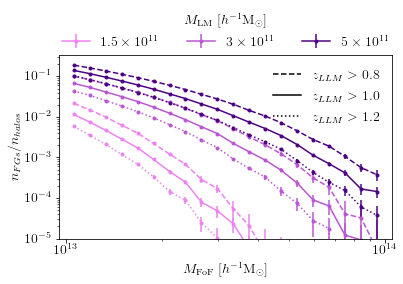

In [13]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.83, 3.5), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

# Load in the fg fraction data
mystery_bus = np.load('/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_fractions.npz')

# Prep for plotting
fig, ax = plt.subplots()
dexes = np.logspace(13, 14, 21)
bin_centers = (dexes[:-1] + dexes[1:]) / 2
linestyles = ["--", "-", ":"]
ls_labels = [r"$z_{LLM}>0.8$", r"$z_{LLM}>1.0$", r"$z_{LLM}>1.2$"] # Could also get from 'lm_masses', but that's more work
colors = ["violet", "mediumorchid", "indigo"]
c_labels = [r"$1.5\times 10^{11}$", r"$3\times 10^{11}$", r"$5\times 10^{11}$"] # h^{-1}\mathrm{M}_{\odot}

for i, this_z_cutoff in enumerate(mystery_bus['fg_fraction'][1:4]): # loop over z-cutoffs (linestyles)
    for j, this_lm_thresh in enumerate(this_z_cutoff): # loop over llm mass thresholds (colors)
        errors = calc_Poisson_errors(mystery_bus['fg_counts'][i][j], mystery_bus['al_counts'])
        #print(errors)
        label = c_labels[j] if i==1 else None
        ax.errorbar(bin_centers, this_lm_thresh, yerr =  errors, marker = '.', label = label, color = colors[j], linestyle = linestyles[i])

legend1 = ax.legend(loc = "upper center", frameon = False, ncol = 3, bbox_to_anchor=(0.5, 1.3), title = r"$M_\mathrm{LM} \; [h^{-1} \mathrm{M}_\odot]$") # Using lines instead of patches here, because I want to show error bars

# Legend for z-cutoffs (linestyles)
fake_lines2 = [ax.plot([],[], linestyle = this_linestyle, c = 'k')[0] for this_linestyle in linestyles]
ax.legend(handles = fake_lines2, labels = ls_labels, loc = "upper right", frameon = False)
#ax.legend(handles = fake_lines2, labels = ls_labels, loc = "upper center", frameon = False, ncol = 3, bbox_to_anchor=(0.45, 1.25))
ax.add_artist(legend1)

# Cosmetics
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom = 1e-5)
ax.set_xlabel(r"$M_\mathrm{FoF}$ $[h^{-1} \mathrm{M}_{\odot}]$")
ax.set_ylabel("$n_{FGs} / n_{halos}$") # How to indicate this is the total?
plt.tight_layout()
#fig.savefig("full_lj_plots/fg_fractions_by_bin_log-log.png", bbox_inches='tight', pad_inches=0)

### Try different z_LLM's

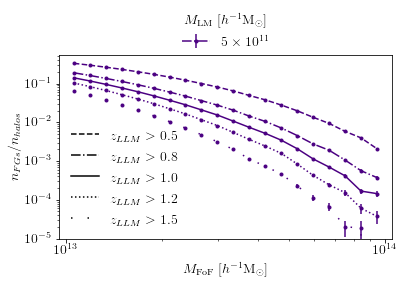

In [14]:
# Same with 0.5 and 1.5
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.83, 3.5), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

# Load in the fg fraction data
mystery_bus = np.load('/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_fractions.npz')
# Order of dimensions (of fg_counts and al_counts): lm_zs, lm_masses, mass_bins

# Prep for plotting
fig, ax = plt.subplots()
dexes = np.logspace(13, 14, 21)
bin_centers = (dexes[:-1] + dexes[1:]) / 2
linestyles = ["--", "-.", "-", ":", (0, (1, 10))]
ls_labels = [r"$z_{LLM}>0.5$", r"$z_{LLM}>0.8$", r"$z_{LLM}>1.0$", r"$z_{LLM}>1.2$", r"$z_{LLM}>1.5$"] # Could also get from 'lm_masses', but that's more work
colors = ["violet", "mediumorchid", "indigo"]
c_labels = [r"$1.5\times 10^{11}$", r"$3\times 10^{11}$", r"$5\times 10^{11}$"] # h^{-1}\mathrm{M}_{\odot}

for i, this_z_cutoff in enumerate(mystery_bus['fg_fraction']): # loop over z-cutoffs (linestyles)
    j = 2
    this_lm_thresh = this_z_cutoff[j]
    #for j, this_lm_thresh in enumerate(this_z_cutoff[2]): # loop over llm mass thresholds (colors)
    errors = calc_Poisson_errors(mystery_bus['fg_counts'][i][j], mystery_bus['al_counts'])
    label = c_labels[j] if i==1 else None
    ax.errorbar(bin_centers, this_lm_thresh, yerr =  errors, marker = '.', label = label, color = colors[j], linestyle = linestyles[i])

legend1 = ax.legend(loc = "upper center", frameon = False, ncol = 3, bbox_to_anchor=(0.5, 1.3), title = r"$M_\mathrm{LM} \; [h^{-1} \mathrm{M}_\odot]$") # Using lines instead of patches here, because I want to show error bars

# Legend for z-cutoffs (linestyles)
fake_lines2 = [ax.plot([],[], linestyle = this_linestyle, c = 'k')[0] for this_linestyle in linestyles]
ax.legend(handles = fake_lines2, labels = ls_labels, loc = "lower left", frameon = False)
#ax.legend(handles = fake_lines2, labels = ls_labels, loc = "upper center", frameon = False, ncol = 3, bbox_to_anchor=(0.45, 1.25))
ax.add_artist(legend1)

# Cosmetics
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom = 1e-5)
ax.set_xlabel(r"$M_\mathrm{FoF}$ $[h^{-1} \mathrm{M}_{\odot}]$")
ax.set_ylabel("$n_{FGs} / n_{halos}$") # How to indicate this is the total?
plt.tight_layout()
#fig.savefig("full_lj_plots/fg_fractions_by_bin_all_zs_lm5.pdf", bbox_inches='tight', pad_inches=0)

### Another way: manually load forests with different M_lm thresholds
(Not necessary: the first approach works fine. Just documenting this for posterity)

In [ ]:
# Takes a long time, and isn't necessary for this notebook,
# so default is to skip this cell
skip = True
if not skip:
    fg_forest_lm3, fg_progenitor_array_lm3 = haccytrees.mergertrees.read_forest(
        "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_lm3e11.hdf5",
        'LastJourney',
        mass_threshold=3e11
    )

    fg_forest_lm15, fg_progenitor_array_lm15 = haccytrees.mergertrees.read_forest(
        "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_lm1.5e11.hdf5",
        'LastJourney',
        mass_threshold=1.5*10**11
    )

    # Could create fg_catalogs
    mask_z0 = fg_forest_lm3['snapnum'] == 100
    fg_catalog_lm3 = {k: fg_forest_lm3[k][mask_z0] for k in fg_forest_lm3.keys()} # forest data at z=0
    s = np.argsort(fg_catalog_lm3['tree_node_index']) # Why do we need this sorting?
    fg_catalog_lm3 = {k: fg_catalog_lm3[k][s] for k in fg_catalog_lm3.keys()}

    mask_z0 = fg_forest_lm15['snapnum'] == 100
    fg_catalog_lm15 = {k: fg_forest_lm15[k][mask_z0] for k in fg_forest_lm15.keys()} # forest data at z=0
    s = np.argsort(fg_catalog_lm15['tree_node_index']) # Why do we need this sorting?
    fg_catalog_lm15 = {k: fg_catalog_lm15[k][s] for k in fg_catalog_lm15.keys()}
    
    # Or mask like normal
    fg_masks_lm5 = help_func_haccytrees.make_masks(fg_catalog_lm5, pre_masked_z0 = True) # previously this was forest? Will that be a problem? # I think catalog is just a forest at z = 0
    fg_masks_lm3 = help_func_haccytrees.make_masks(fg_catalog_lm3, pre_masked_z0 = True)
    fg_masks_lm15 = help_func_haccytrees.make_masks(fg_catalog_lm15, pre_masked_z0 = True)

## Old approaches
(Before we decided to use narrow mass bins)

### Abundances by thirds

In [13]:
mass_mask = (data['tree_node_mass'] > 1e13) & (data['tree_node_mass'] < 1e14)
sorted_idx = np.argsort(data['tree_node_mass'][mass_mask])
mass_onethird = np.quantile(data['tree_node_mass'][mass_mask][sorted_idx], 1/3) # Huh, comes up with a slightly different value? Ohhh cause the other version rounds (why?)
mass_twothirds = np.quantile(data['tree_node_mass'][mass_mask][sorted_idx], 2/3)
thirds = [1e13, mass_onethird, mass_twothirds, 1e14]
print("Bin edges: ", np.log10(thirds))

bins_by_thirds = [[thirds[i], thirds[i+1]] for i in range(len(thirds) - 1)]
thirds_masks = make_masks(data, bins_by_thirds)
fg_thirds_masks = make_masks(fg_catalog_lm5, bins_by_thirds)

print("Halo counts by bin: ", [len(mask[mask]) for mask in thirds_masks])
print("FG counts by bin:   ", [len(mask[mask]) for mask in fg_thirds_masks])
print("Fractions by bin:   ", np.array([len(mask[mask]) for mask in fg_thirds_masks]) / np.array([len(mask[mask]) for mask in thirds_masks]))

halo_sum = 0
fg_sum = 0
for halo_mask, fg_mask in zip(thirds_masks, fg_thirds_masks):
    halo_sum += len(halo_mask[halo_mask])
    fg_sum += len(fg_mask[fg_mask])
    
print("Total halos:    ", halo_sum)
print("Total fgs:      ", fg_sum)
print("Total fraction: ", fg_sum / halo_sum)
print("Error:          ", calc_Poisson_errors(halo_sum, fg_sum))

Bin edges:  [13.         13.15356712 13.39051353 14.        ]
Halo counts by bin:  [5273458, 5276279, 5275927]
FG counts by bin:    [624726, 282177, 46312]
Fractions by bin:    [0.1184661  0.0534803  0.00877798]
Total halos:     15825664
Total fgs:       953215
Total fraction:  0.06023222785470486
Error:           0.01750959656383597


### Abundances in narrow mass bins

In [58]:
halo_counts = [len(mask[mask]) for mask in halo_masks]
fg_counts = [len(mask[mask]) for mask in fg_masks_lm5]
fraction = np.array(fg_counts) / np.array(halo_counts)
qh_counts = []
for this_mask in fg_masks_lm5:
    target_idx = np.nonzero(this_mask)[0]
    my_forest = fg_forest_lm5 # Make sure this is the same as what you fed to `make_masks()`
    my_progenitor_array = fg_progenitor_array_lm5
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, my_forest)
    mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(my_forest, my_progenitor_array, mainbranch_index)
    major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
    lmm_redshifts = help_func_haccytrees.get_lmms(major_mergers)
    fgs, rugs, mrich = help_func_haccytrees.find_specials(my_forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx)
    qh_counts.append(len(rugs))
    
qh_fraction = np.array(qh_counts) / np.array(fg_counts)

halo_std = [count**(1/2) for count in halo_counts]
fg_std = [count**(1/2) for count in fg_counts]
fraction_error = calc_Poisson_errors(np.array(fg_counts), np.array(halo_counts))
qh_fraction_error = calc_Poisson_errors(np.array(qh_counts), np.array(fg_counts))

print("Halo counts by bin:         ", halo_counts)
print("Halo error:                 ", halo_std)
print("FG counts by bin:           ", fg_counts)
print("FG error:                   ", fg_std)
print("FG fractions by bin:        ", fraction)
print("FG frac uncertainty by bin: ", fraction_error)
print("qh counts by bin:           ", qh_counts)
print("qh fractions by bin:        ", qh_fraction)
print("qh frac uncertainty by bin: ", qh_fraction_error)

Halo counts by bin:          [1919589, 975970, 474295]
Halo error:                  [1385.4923312671203, 987.9119393954098, 688.6907869283573]
FG counts by bin:            [269358, 36181, 2454]
FG error:                    [518.9971098185423, 190.21303845951255, 49.53786430600334]
FG fractions by bin:         [0.14032066 0.03707184 0.005174  ]
FG frac uncertainty by bin:  [0.00028872 0.00019848 0.00010472]
qh counts by bin:            [30077, 294, 0]
qh fractions by bin:         [0.1116618  0.00812581 0.        ]
qh frac uncertainty by bin:  [0.00067885 0.00047583 0.        ]


In [59]:
# In total
total_fgs = 953215
total_halos = 15825664
print(total_fgs / total_halos)
total_fraction_error = calc_Poisson_errors(total_fgs, total_halos)
print(total_fraction_error)
print(0.006 * 10**(-2))

my_forest = fg_forest_lm5 # Make sure this is the same as what you fed to `make_masks()`
my_progenitor_array = fg_progenitor_array_lm5
target_idx = help_func_haccytrees.find_halos(my_forest, [1e13, 1e14])
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, my_forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(my_forest, my_progenitor_array, mainbranch_index)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
lmm_redshifts = help_func_haccytrees.get_lmms(major_mergers)
fgs, rugs, mrich = help_func_haccytrees.find_specials(my_forest, mainbranch_index, major_mergers, lmm_redshifts, target_idx)
total_qh = len(rugs)

qh_fraction = np.array(total_qh) / np.array(total_fgs)
qh_fraction_error = calc_Poisson_errors(np.array(total_qh), np.array(total_fgs))
print(qh_fraction)
print(qh_fraction_error)

0.06023222785470486
6.352343784405087e-05
6e-05
0.06294592510608835
0.0002649378222069446
